In [56]:
! pip install datasets

In [57]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [58]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as transforms
import os
import numpy as np
import cv2
import datasets
import pandas as pd
from datasets import load_dataset, DatasetDict
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
import time

In [59]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [60]:
# Random seed for PyTorch
torch.manual_seed(42)

In [61]:
img_path = "/kaggle/input/data"
font_classes = os.listdir(img_path)
# Ignore .DS_store dir
font_classes = font_classes
font_classes

['Holligate Signature',
 'Canterbury',
 'OpenSans',
 'AguafinaScript',
 'alsscrp',
 'James Fajardo',
 'AlexBrush',
 'GreatVibes',
 'I Love Glitter',
 'Allura']

In [62]:
width, height = 500, 300

# Resize image
def processImage(image_path):
  orginal_img = cv2.imread(image_path)
  # img_data = np.array(orginal_img)

  # Upscale or downscale based on dimension
  if orginal_img.shape[1] < width or orginal_img.shape[0] < height:
    resize_img = cv2.resize(orginal_img, (width, height), interpolation= cv2.INTER_CUBIC)
  else:
    resize_img = cv2.resize(orginal_img, (width, height), interpolation= cv2.INTER_AREA)

  return resize_img


In [63]:
images = []
labels = []

In [64]:
for font_class in font_classes:
  # Get all the font images for specific font
  font_dir = os.path.join(img_path, font_class)

  for image_file in os.listdir(font_dir):
      image_path = os.path.join(font_dir, image_file)
      images.append(processImage(image_path))
      labels.append(font_class)



# Encode Labels    
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

data = {'image': images, 'labels': labels}
df = pd.DataFrame(data)

In [65]:
df.image[0].shape

(300, 500, 3)

In [66]:
new_df = df.copy()

In [67]:
# Convert into CxHxW format from HxWxC
for index, row in new_df.iterrows():

    image_tensor = torch.tensor(row['image'])
    image_tensor_permuted = image_tensor.permute(2, 0, 1)

    new_df.at[index, 'image'] = image_tensor_permuted.numpy()

In [68]:
new_df.image[0].shape

(3, 300, 500)

In [69]:
# Custom dataset for DataLoader
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['labels']
        return image, label

In [70]:
custom_dataset = CustomDataset(new_df)

In [90]:
# Parameters
epochs = 5
batch_size = 16
learning_rate = 0.01

In [91]:
all_data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [92]:
# Split into train test validation
total_size = new_df.shape[0]
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
validation_size = total_size - train_size - test_size

In [93]:
train_set, test_set, validation_set = torch.utils.data.random_split(all_data_loader.dataset, [train_size, test_size, validation_size])

In [94]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [95]:
# Show data for 1st batch
def batchImages(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

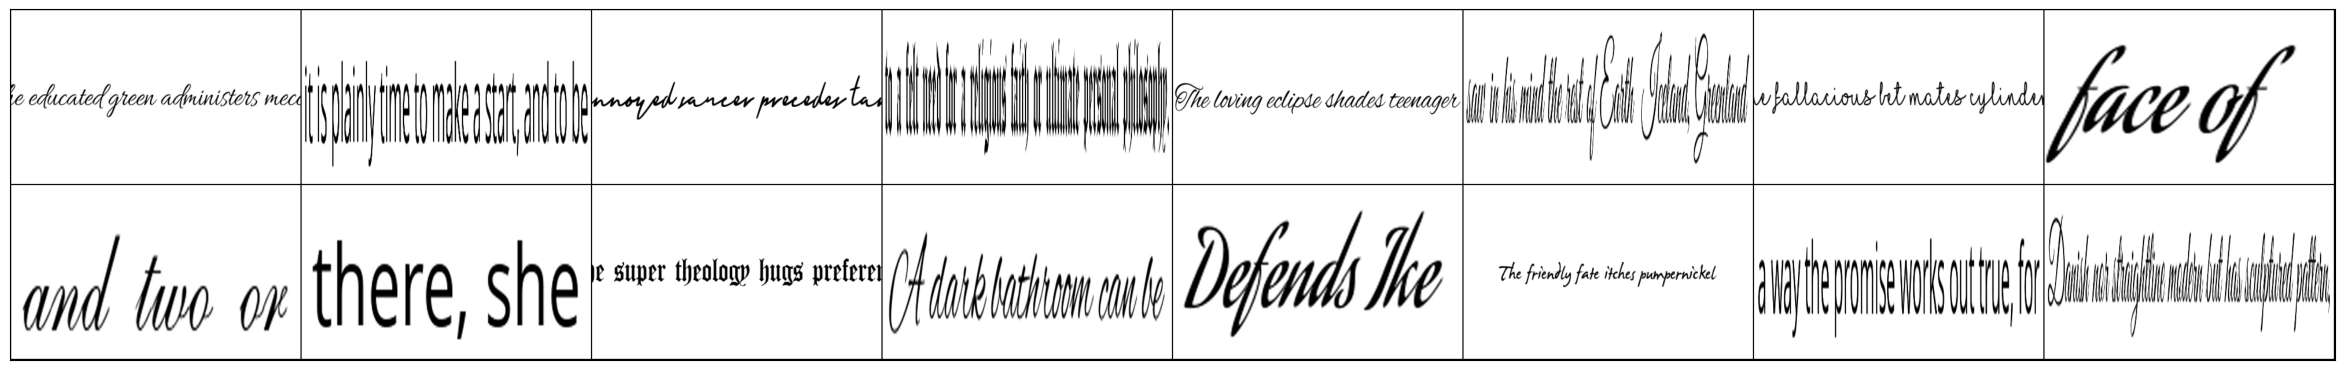

In [96]:
batchImages(train_loader)

In [97]:
# ResNet model -- adding dropout before final layer
model = torchvision.models.resnet18()
features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(features, 10)
)

In [85]:
# del model

In [98]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [99]:
# Model train
steps = new_df.shape[0]
epoch_times = []
model.to(device)
print(f'device -> {device}')

for epoch in range(epochs):
  model.train()
  train_loss = 0
    
  start_time = time.time()

  for image, label in train_loader:
    image = image.to(device).float()
    label = label.to(device)
    # image = image.to(torch.float32)
    
    optimizer.zero_grad()
    # print(image.size())
    
    output = model(image)
    loss = criterion(output, label)

    
    loss.backward()
    optimizer.step()

    # loss.item() -> avg loss per batch, so scale the loss
    train_loss += loss.item() * image.size(0)

  train_loss = train_loss / steps

  model.eval()
  val_loss = 0

  with torch.no_grad():
    for image, label in validation_loader:
      image = image.to(device).float()
      label = label.to(device)
      # image = image.to(torch.float32)
      output = model(image)

      loss = criterion(output, label)
      val_loss += loss.item() * image.size(0)

  val_loss = val_loss / steps

  end_time = time.time()  
  epoch_time = end_time - start_time  
  epoch_times.append(epoch_time)

  print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f} seconds')

average_epoch_time = sum(epoch_times) / len(epoch_times)
print(f'Average Epoch Time: {average_epoch_time:.2f} seconds')

device -> cuda:0
Epoch [1/5], Train Loss: 1.5068, Validation Loss: 0.2545, Epoch Time: 11.72 seconds
Epoch [2/5], Train Loss: 0.9372, Validation Loss: 0.2162, Epoch Time: 11.88 seconds
Epoch [3/5], Train Loss: 0.5902, Validation Loss: 0.0839, Epoch Time: 12.02 seconds
Epoch [4/5], Train Loss: 0.3815, Validation Loss: 0.0572, Epoch Time: 11.92 seconds
Epoch [5/5], Train Loss: 0.2858, Validation Loss: 0.0552, Epoch Time: 11.73 seconds
Average Epoch Time: 11.85 seconds


In [100]:
# Test mode
model.eval()
preds = []
true_labels = []

start_time = time.time()

with torch.no_grad():
  correct_pred = 0
  total_pred = 0
  class_correct = [0] * 10
  class_total = [0] * 10

  for image, label in test_loader:
    image = image.to(device).float()
    label = label.to(device)
    output = model(image)

    values, prediction = torch.max(output.data, 1)
    # preds.append(prediction)
    
    # Add the batch size to total_pred
    total_pred += label.size(0)
    correct_pred += (prediction == label).sum().item()
    # scikit learn functions operate on cpu tensor
    preds.extend(prediction.cpu().numpy())
    true_labels.extend(label.cpu().numpy())
    
    # per class accuracy
    for i in range(len(label)):
        true_label = label[i].item()
        predicted_label = prediction[i].item()
        class_correct[true_label] += int(true_label == predicted_label)
        class_total[true_label] += 1

  
end_time = time.time()  
evaluation_time = end_time - start_time

precision = precision_score(true_labels, preds, average=None)
recall = recall_score(true_labels, preds, average=None)
accuracy_per_class = [100 * correct / total if total > 0 else 0 for correct, total in zip(class_correct, class_total)]


print(f'Accuracy -> {100*correct_pred / total_pred}%, Evaluation Time -> {evaluation_time:.2f} seconds')

Accuracy -> 89.55223880597015%, Evaluation Time -> 0.81 seconds


In [101]:
# Precision and Recall for each class
print(f'Precision -> {precision}')
print(f'Recall -> {recall}')

Precision -> [0.96296296 0.89189189 1.         1.         0.64102564 0.85185185
 1.         1.         1.         0.84375   ]
Recall -> [1.         0.97058824 0.42307692 1.         0.92592593 0.95833333
 0.92307692 0.87096774 1.         0.9       ]


In [102]:
print(f'Accuracy per class -> {accuracy_per_class}')

Accuracy per class -> [100.0, 97.05882352941177, 42.30769230769231, 100.0, 92.5925925925926, 95.83333333333333, 92.3076923076923, 87.09677419354838, 100.0, 90.0]


In [84]:
# save model
torch.save(model.state_dict(), 'resnet.ckpt')